## Verrijkte kleinverbruikergegevens
Creer een nieuwe dataset obv de NEDU profielen en de kleinverbruikergegevens. De nieuwe dataset bevat dan het kleinverbruik per dag per postcode.

De stappen die genomen worden zijn:

1. Inlezen h5 bestanden met de NEDU profielen en kleinverbruikergegevens
2. Voeg profiel toe aan kleinverbruikergegevens
3. Transformeer NEDU profielen set tot een verbruik per dag ipv verbruik per kwartier
4. Nieuw dataframe opbouwen met per dag de volgende data:
* Datum
* Verbruik
* Postcode
* Aantal aansluitingen

Om het juiste profiel te bepalen nemen we 2 dingen mee:
* Wat is percentage meters met een Laag/Hoog tarief. Als dit percentage lager is dan 30% wordt het gebied in een A profiel gezet.
* Ligt het gebied in Noord of Zuid-Nederland. Dit wordt gebruikt om te bepalen of het gebied een E1B of E1C profiel krijgt.

Het verbruik wordt berekend door het verbruik van het profiel behorende bij de postcode te sommeren voor een dag.

In [11]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import plot_importance, plot_tree


# show all columns in the dataframe
pd.set_option('max_columns', None)

In [12]:
os.getcwd()

'C:\\Users\\jcdek\\OneDrive\\Documents\\GitHub\\jads_enexis\\data\\processed'

In [33]:
# variables used in script
data_processed_location = '../data/processed'

if 'processed' not in os.getcwd():
    os.chdir(data_processed_location)

# kleinverbruikgegevens gegevens inlezen
df_pc4_5211 = pd.read_hdf('pc4_verbruiksdata_per_dag_5211.h5')


In [34]:
df_pc4_5211.head()

,VERBRUIK
DATUM,
2010-01-01,69.210361
2010-01-02,67.161735
2010-01-03,64.971068
2010-01-04,60.439058
2010-01-05,52.102170


<AxesSubplot:title={'center':'Daily Electricity Consumption for PC4 5211'}, xlabel='DATUM'>

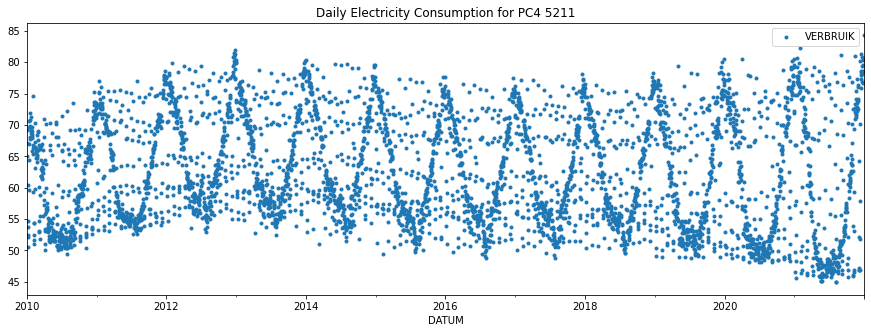

In [35]:
# Time series plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='MW per day', dpi=100):
    plt.figure(figsize=(30,10), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

df_pc4_5211.plot(style='.', figsize=(15,5), title='Daily Electricity Consumption for PC4 5211')  

### Building Training/ Test Samples

In [48]:
split_date = '01-Jan-2018'
df_pc4_5211_train = df_pc4_5211.loc[df_pc4_5211.index <= split_date].copy()
df_pc4_5211_test = df_pc4_5211.loc[df_pc4_5211.index > split_date].copy()
print (f'Length full     dataset: {len(df_pc4_5211)} samples')
print (f'Length training dataset: {len(df_pc4_5211_train)} samples')
print (f'Length test     dataset: {len(df_pc4_5211_test)} samples')


Length full     dataset: 4383 samples
Length training dataset: 2923 samples
Length test     dataset: 1460 samples


### Feature engineering

In [49]:
# Create features from datetime index
def create_features(df, label=None):
    df['date'] = df.index
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['quarter'] = df['date'].dt.quarter
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['dayofweek','month', 'quarter', 'year', 'dayofyear',
            'dayofmonth', 'weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [50]:
df_pc4_5211_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2923 entries, 2010-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   VERBRUIK  2923 non-null   float64
dtypes: float64(1)
memory usage: 45.7 KB


In [51]:
X_train, y_train = create_features(df_pc4_5211_train, label='VERBRUIK')
X_test, y_test = create_features(df_pc4_5211_test, label='VERBRUIK')

<ipython-input-49-5f3341a1f3b6>:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


### Build XGBoost Model

In [52]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds = 50,
        verbose = False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

### Plot Feature Importances

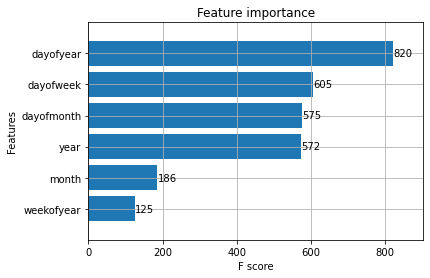

In [53]:
plot_importance(reg, height=0.8);

### Forecast on Test Set

In [54]:
df_pc4_5211_test['Forecast'] = reg.predict(X_test)

In [55]:
df_pc4_5211_test.head(5)

,VERBRUIK,date,dayofweek,month,quarter,year,dayofyear,dayofmonth,weekofyear,Forecast
DATUM,,,,,,,,,,
2018-01-02,71.116623,2018-01-02,1,1,1,2018,2,2,1,70.650078
2018-01-03,66.975748,2018-01-03,2,1,1,2018,3,3,1,67.571999
2018-01-04,60.742610,2018-01-04,3,1,1,2018,4,4,1,61.593689
2018-01-05,57.668550,2018-01-05,4,1,1,2018,5,5,1,56.597511
2018-01-06,54.628802,2018-01-06,5,1,1,2018,6,6,1,54.490044


In [56]:
df_pc4_5211_all = pd.concat([df_pc4_5211_test, df_pc4_5211_train], sort = False)

### 2010-2021

<AxesSubplot:xlabel='DATUM'>

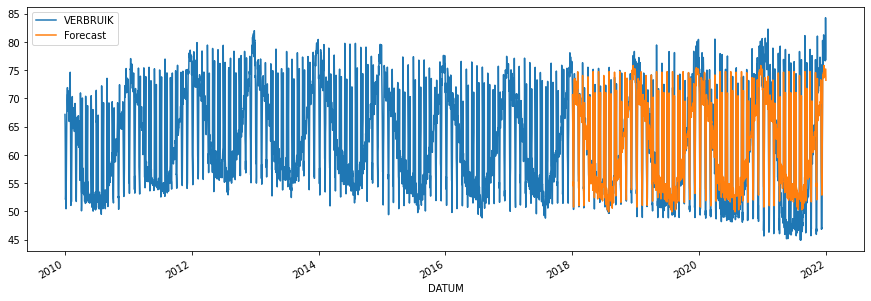

In [57]:
df_pc4_5211_all.loc[df_pc4_5211_all.index > '1-Jan-2010'][['VERBRUIK', 'Forecast']].plot(figsize=(15,5))

### 2020-2021

<AxesSubplot:xlabel='DATUM'>

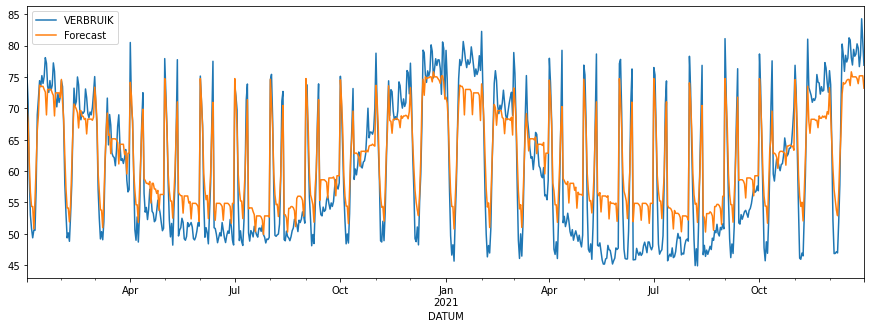

In [79]:
df_pc4_5211_all.loc[df_pc4_5211_all.index > '1-Jan-2020'][['VERBRUIK', 'Forecast']].plot(figsize=(15,5))

### 1-Jan - 1-Apr 2018

<AxesSubplot:xlabel='DATUM'>

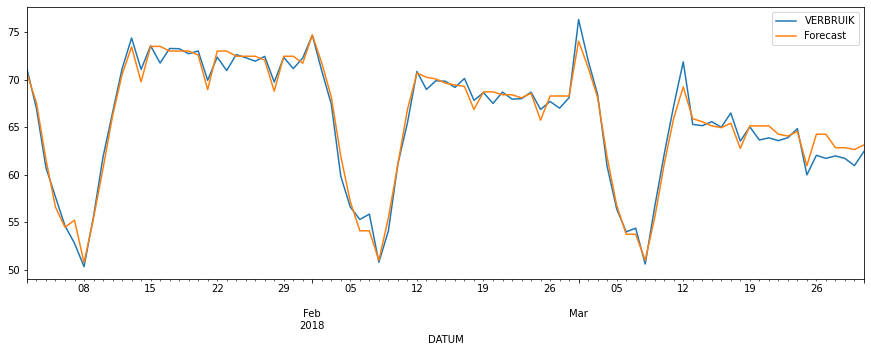

In [63]:
df_pc4_5211_all.loc[(df_pc4_5211_all.index > '1-Jan-2018') & (df_pc4_5211_all.index < '1-Apr-2018')][['VERBRUIK', 'Forecast']].plot(figsize=(15,5))

### 1-Jan - 1-Apr 2019

<AxesSubplot:xlabel='DATUM'>

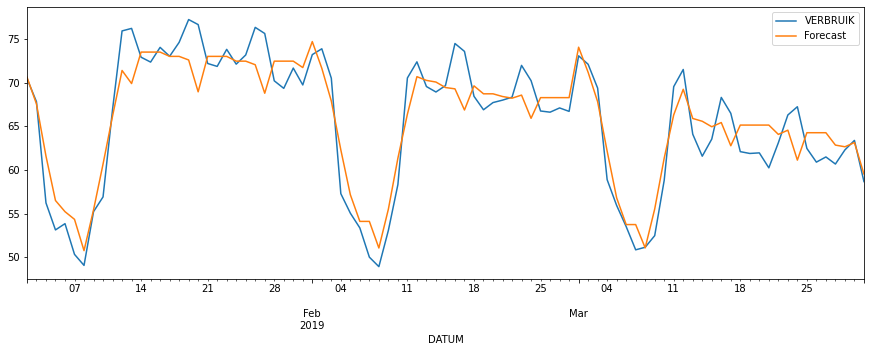

In [64]:
df_pc4_5211_all.loc[(df_pc4_5211_all.index > '1-Jan-2019') & (df_pc4_5211_all.index < '1-Apr-2019')][['VERBRUIK', 'Forecast']].plot(figsize=(15,5))

### 1-Jan - 1-Apr 2020

<AxesSubplot:xlabel='DATUM'>

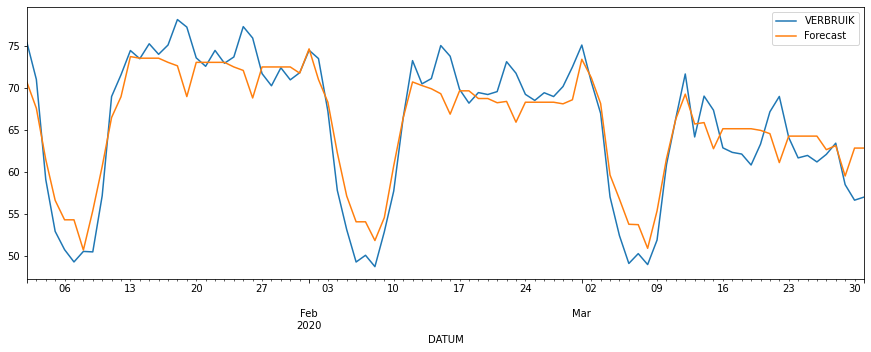

In [59]:
df_pc4_5211_all.loc[(df_pc4_5211_all.index > '1-Jan-2020') & (df_pc4_5211_all.index < '1-Apr-2020')][['VERBRUIK', 'Forecast']].plot(figsize=(15,5))

### 1-Jan - 1-Apr 2021

<AxesSubplot:xlabel='DATUM'>

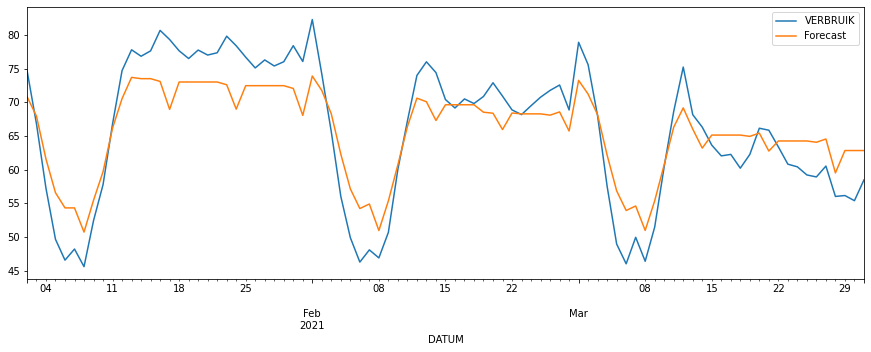

In [65]:
df_pc4_5211_all.loc[(df_pc4_5211_all.index > '1-Jan-2021') & (df_pc4_5211_all.index < '1-Apr-2021')][['VERBRUIK', 'Forecast']].plot(figsize=(15,5))

### Evaluate the Performance

In [68]:
# The MAPE (Mean Absolute Percent Error) measures the size of the error
# in percentage terms.
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [69]:
# Make predictions using the training and testing set
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

In [77]:
print('R^2   train: %.2f, test: %.2f' % (r2_score(y_train, y_train_pred),
                                       r2_score(y_test, y_test_pred)))

print('MSE   train: %.2f, test: %.2f' %
      (mean_squared_error(y_train, y_train_pred),
       mean_squared_error(y_test, y_test_pred)))

print('RMSE  train: %.2f, test: %.2f' %
      (np.sqrt(mean_squared_error(y_train, y_train_pred)),
       np.sqrt(mean_squared_error(y_test, y_test_pred))))

print('MAE   train: %.2f, test: %.2f' %
      (mean_absolute_error(y_train, y_train_pred),
       mean_absolute_error(y_test, y_test_pred)))

print('MAPE  train: %.2f, test: %.2f' %
      (mean_absolute_percentage_error(y_train, y_train_pred),
       mean_absolute_percentage_error(y_test, y_test_pred)))

print(f'\nMean absolute percent accuracy: {100 - mean_absolute_percentage_error(y_test, y_test_pred):.2f}%')

R^2   train: 0.97, test: 0.86
MSE   train: 1.73, test: 13.46
RMSE  train: 1.32, test: 3.67
MAE   train: 1.03, test: 2.83
MAPE  train: 1.64, test: 4.95

Mean absolute percent accuracy: 95.05%
